# Deep Learning Exercise
Below you'll find a data science exercise that may be solved with deep learning techniques.  While you're encouraged to use deep learning, this problem can certainly be solved other ways.  Be sure to document your thought processes and justify *why* you used your solution.

## Limits
You shouldn't spend longer than 1-2 hours on this challenge.  You won't be timed so be sure to relax and choose a time that suits you.  It's perfectly acceptable if you don't complete the exercise.  Just be sure to document your progress and explain your strategies.  You're encouraged to use and cite prior research.

## The Problem
The goal of this exercise is to build a reliable heartbeat detector given electrocardiogram (ECG) data.

## The Data
For this exercise we'll be using ECG data from the [MIT-BIH Arrhythmia Database](https://www.physionet.org/physiobank/database/mitdb/).  There's a handy tool [here](https://physionet.org/cgi-bin/atm/ATM) for converting this data to more usable formats.  The first data file, `100m.mat`, is already in the same directory as this notebook so you won't need to download anything unless you wish to collect more data.  If you do, use the [ATM](https://physionet.org/cgi-bin/atm/ATM) to export `.mat` files.  The annotations are obtained by selecting `Show annotations as text`.  Be sure to move the `Aux` column if you import more annotations.

## Let's get started!

In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

## Importing ECG data
We'll start by importing our ECG data.  There are two channels available and we'll be using the MLII channel.

In [47]:
signals = io.loadmat('100m.mat.bz2')
annotations = np.genfromtxt('annotations.txt',
                            dtype=[('time','|S9'),('sample','f'),('type','|S1')],
                            skip_header=1)

# The first channel contains MLII recordings
mlii_samples = signals['val'][0]

ValueError: Unknown mat file type, version 97, 92

Let's check out what this data looks like.  Hopefully we'll see a heartbeat!

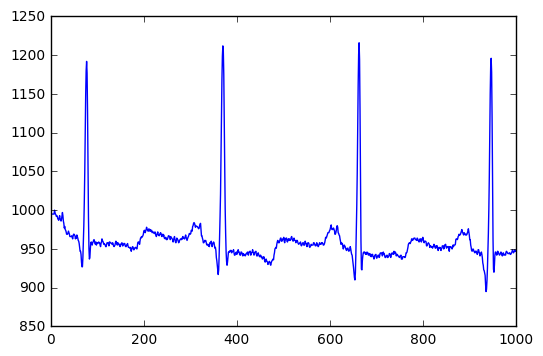

In [42]:
plt.plot(mlii_samples[:1000])

For training, we'll divide this data into a number of random 1000 sample long chunks.  We'll generate two sets of data: the raw samples and their spectral counterparts.

In [43]:
chunk_size = 1000
sample_size = 1000

# Generate random chunk indexes
sample_chunk_idx = np.random.randint(1, mlii_samples.size - chunk_size, sample_size)
sample_chunk_idx = np.array(np.rot90([sample_chunk_idx, sample_chunk_idx + chunk_size]))

sample_chunks = []
sample_chunks_f = []

# We'll use this hamming window for the STFT
stft_size = 32
hamming_window = signal.get_window('hamming', stft_size)

# Construct our main sample data set
for range in sample_chunk_idx:
  sample_chunks.append(mlii_samples[range[0]: range[1]])

# Things tend to work slightly better when rescaled to 0..1
scaler = MinMaxScaler(feature_range=(0, 1))
sample_chunks = scaler.fit_transform(sample_chunks)

# Compute the spectra for each chunk
for sample in sample_chunks:
  f, t, Zxx = signal.stft(sample, window = hamming_window, nperseg = stft_size)
  sample_chunks_f.append(np.abs(Zxx))

# Recast as a numpy array
sample_chunks_f = np.asarray(sample_chunks_f)

Our two sets of sample data now look like:

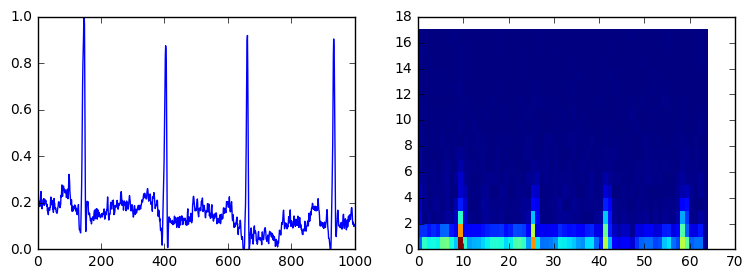

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(sample_chunks[0])
axs[1].pcolormesh(sample_chunks_f[0])

Now for our label data.  We'll construct a few label sets: indexes and one-hot encoded for both raw and spectra.

In [45]:
beats = annotations['sample']
sample_beats = []
sample_beats_oh = np.zeros((sample_size, chunk_size), dtype = int)
sample_beats_f_oh = np.zeros((sample_size, sample_chunks_f.shape[2]), dtype = int)

for i, chunk in enumerate(sample_chunk_idx):
    sample_beats.append(beats[np.where(np.logical_and(beats >= chunk[0], beats <= chunk[1]))])
    offset_beats = ((sample_beats[i] - sample_chunk_idx[i][0]) - 1).astype(int)
    sample_beats_oh[i, offset_beats] = 1
    sample_beats_f_oh[i, offset_beats / stft_size / 2] = 1

# Recast as numpy array
sample_beats = np.asarray(sample_beats)

Let's plot our sample data together with our label data to ensure they line up:

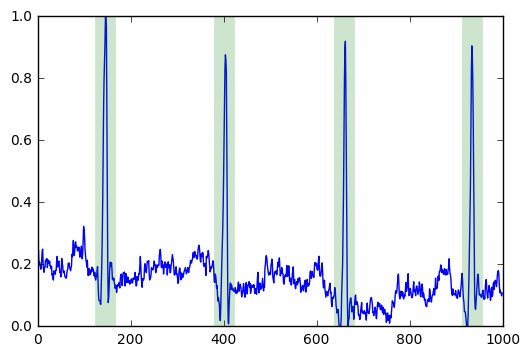

In [46]:
plt.plot(sample_chunks[0])
for xc in np.where(sample_beats_oh[0] == 1)[0]:
    plt.axvline(x = xc, linewidth=15, color='g', alpha=0.2)

Now it's your turn!  Using any or all of the data sets provided, build a deep learning model that predicts the location of heartbeats given a sample of ECG data.

To summarize your available data:

    sample_chunks: raw samples
    sample_beats: beat index locations (0-indexed)
    sample_beats_oh: one-hot encoded beat locations
    sample_chunks_f: spectra of samples
    sample_beats_f_oh: beat index locations for spectra